## Outline

 - Create synthetic class imbalance
 - Load and preprocess data
 - Create `DataLoaders` for train and test sets
 - Define the model: one hidden layer
 - Train and evaluate model using grid search to select hidden layer size
 - Model selection
 - Visualisation

## Setup

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## Load and preprocess data

In [4]:
def make_imbalanced(X, y, target_counts):
    """
    X : np.array (n_samples, n_features)
    y : np.array (n_samples,)
    target_counts : dict {class_label: desired_count}
      - if desired_count > available -> oversample with replacement
      - if desired_count <= available -> subsample without replacement
    Returns: X_res, y_res (numpy arrays)
    """
    np.random.seed(SEED)
    X_res_list, y_res_list = [], []
    classes = np.unique(y)

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        avail = len(cls_idx)
        desired = target_counts.get(int(cls), avail)  # default keep same if not specified
        if desired <= 0:
            continue
        if desired <= avail: # undersample without replacement
            chosen = np.random.choice(cls_idx, size=desired, replace=False)
        else: # oversample with replacement
            chosen = np.random.choice(cls_idx, size=desired, replace=True)
        X_res_list.append(X[chosen])
        y_res_list.append(y[chosen])

    X_res = np.vstack(X_res_list)
    y_res = np.concatenate(y_res_list)

    # shuffle resampled dataset
    perm = np.random.permutation(len(y_res))
    return X_res[perm], y_res[perm]

(150, 4) (150,)
Original class distribution: Counter({0: 50, 1: 50, 2: 50})


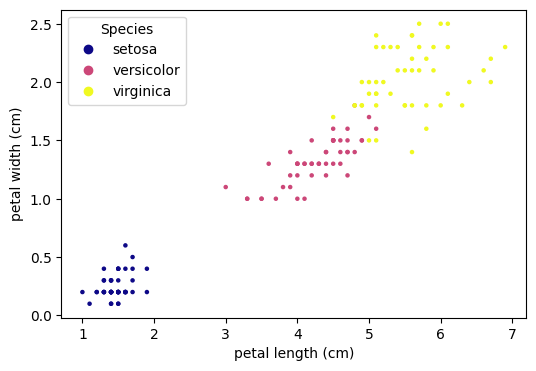

In [5]:
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape, y.shape)

print("Original class distribution:", Counter(y))

plt.figure(figsize=(6,4))
scatter = plt.scatter(X[:, 2], X[:, 3], c=y, s=5, cmap='plasma')
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
handles, _ = scatter.legend_elements()
plt.legend(handles, iris.target_names, title="Species")
plt.show()

Resampled class distribution: Counter({1: 100, 2: 30, 0: 20})


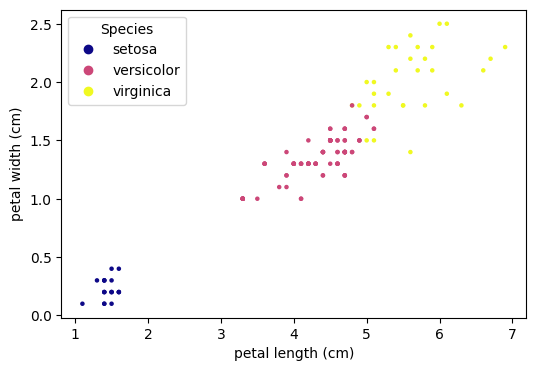

In [6]:
X_imb, y_imb = make_imbalanced(X, y, target_counts={0: 20, 1: 100, 2: 30})
print("Resampled class distribution:", Counter(y_imb))

plt.figure(figsize=(6,4))
scatter = plt.scatter(X_imb[:, 2], X_imb[:, 3], c=y_imb, s=5, cmap='plasma')
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
handles, _ = scatter.legend_elements()
plt.legend(handles, iris.target_names, title="Species")
plt.show()

Normalise inputs ([Source](https://www.researchgate.net/publication/2811922_Efficient_BackProp))

In [7]:
scaler = StandardScaler()
X_imb = scaler.fit_transform(X_imb)

In [8]:
# train-test split
# stratify using class labels of imbalanced data set
X_train, X_valid, y_train, y_valid = train_test_split(X_imb, y_imb, train_size=0.8, random_state=SEED, stratify=y_imb)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size=0.8, random_state=SEED, stratify=y_valid)

In [ ]:
# create dataloaders
# first create tensors from np.arrays returned by train_test_split
# then create a torch Dataset
# then wrap an iterable around it to create a torch DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds  = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# Vanilla model

## Define model

In [10]:
class IrisNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(IrisNN, self).__init__()
        
        if hidden_size == 0: # just a linear model
            self.net = nn.Linear(in_features= input_size, out_features= output_size)
        else:
            self.net = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, output_size)
            )
            # don't include softmax here, CrossEntropyLoss does that internally
    
    def forward(self, x):
        return self.net(x)


## Training

In [11]:
def tune_iris(hidden, output_size, epochs, lr, 
              train_loader, test_loader, 
              classes_incl = iris.target_names, verbose=True):
    # specify architecture
    model = IrisNN(input_size=4, hidden_size=hidden, output_size=output_size)
    loss_func = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=lr)

    # record performance for later plotting
    train_perf = []
    test_perf = []
    num_epochs_used = 50

    # early stopping variables
    # prev_acc = -float("inf")
    test_acc = -float("inf")
    # best_epoch = 0
    # patience_counter = 0
    # patience = 7
    # best_state = None

    # train and evaluate for each epoch
    for epoch in range(epochs):
        # training
        model.train()
        for (xb, yb) in train_loader:
            optimiser.zero_grad() # reset gradients from previous batch
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            optimiser.step()

        # evaluation   
        model.eval()
        with torch.no_grad():
            # training performance
            tr_preds, tr_targets = [], []
            for xb, yb in train_loader:
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                tr_targets.append(yb.numpy())
                tr_preds.append(preds.numpy()) 
            
            tr_preds = np.concatenate(tr_preds)
                        
            tr_targets = np.concatenate(tr_targets)
            train_acc = balanced_accuracy_score(tr_targets, tr_preds)

            # test performance
            te_preds, te_targets = [], []
            for xb, yb in test_loader:
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                te_targets.append(yb.numpy())
                te_preds.append(preds.numpy()) 
                
            te_preds = np.concatenate(te_preds)
            te_targets = np.concatenate(te_targets)
            test_acc = balanced_accuracy_score(te_targets, te_preds)

            if test_acc > 0.95:                
                train_perf.append(train_acc)
                test_perf.append(test_acc)
                num_epochs_used = epoch + 1 

                print(f"Satisfactory performance reached at epoch {num_epochs_used}, te_bal_acc={test_perf[-1]:.3f}")

                break

            if verbose and ((epoch + 1) % 10 == 0 or epoch == 0):
                print(f"h={hidden} Epoch {epoch+1}/{epochs} | tr_bal_acc={train_acc:.3f} te_bal_acc={test_acc:.3f}")
    
        train_perf.append(train_acc)
        test_perf.append(test_acc)

        # early stopping
    #     if test_acc > prev_acc:
    #         best_epoch = epoch
    #         patience_counter = 0
    #         best_state = model.state_dict()  # keep best weights
    #     else:
    #         patience_counter += 1

    #     if patience_counter >= patience:
    #         if verbose:
    #             print(f"Early stopping at epoch {epoch+1} (best epoch={best_epoch+1}")
    #             num_epochs_used = epoch + 1
    #         break

    # # restore best model state
    # if best_state is not None:
    #     model.load_state_dict(best_state)

    # classification report printed at end of training
    report = classification_report(
        te_targets, 
        te_preds, 
        target_names=classes_incl,
        zero_division=0,
        digits=3 
    )

    print(report)
    
    return train_perf, test_perf, num_epochs_used

In [12]:
Counter(y_train)

Counter({1: 80, 2: 24, 0: 16})

In [13]:
hidden_sizes = [0, 1, 2, 4, 8, 16, 32]
epochs = 50
results = {}

SEED = 43
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

for h in hidden_sizes:
    print(f"\n=== Full model with hidden_size = {h} ===")
    train_hist, test_hist, num_epochs = tune_iris(hidden=h, output_size=3, epochs=epochs, lr=0.01,
                                                  train_loader=train_loader, test_loader=test_loader, 
                                                  verbose=True)
    results[h] = {"train": train_hist, "test": test_hist, "num_epochs_used": num_epochs}


=== Full model with hidden_size = 0 ===
h=0 Epoch 1/50 | tr_bal_acc=0.474 te_bal_acc=0.542
Satisfactory performance reached at epoch 7, te_bal_acc=0.958
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000         3
  versicolor      1.000     0.875     0.933        16
   virginica      0.714     1.000     0.833         5

    accuracy                          0.917        24
   macro avg      0.905     0.958     0.922        24
weighted avg      0.940     0.917     0.921        24


=== Full model with hidden_size = 1 ===
h=1 Epoch 1/50 | tr_bal_acc=0.333 te_bal_acc=0.333
h=1 Epoch 10/50 | tr_bal_acc=0.333 te_bal_acc=0.333
h=1 Epoch 20/50 | tr_bal_acc=0.639 te_bal_acc=0.667
h=1 Epoch 30/50 | tr_bal_acc=0.644 te_bal_acc=0.667
h=1 Epoch 40/50 | tr_bal_acc=0.644 te_bal_acc=0.667
h=1 Epoch 50/50 | tr_bal_acc=0.644 te_bal_acc=0.667
              precision    recall  f1-score   support

      setosa      0.000     0.000     0.000         3
  ve

### Visualisation

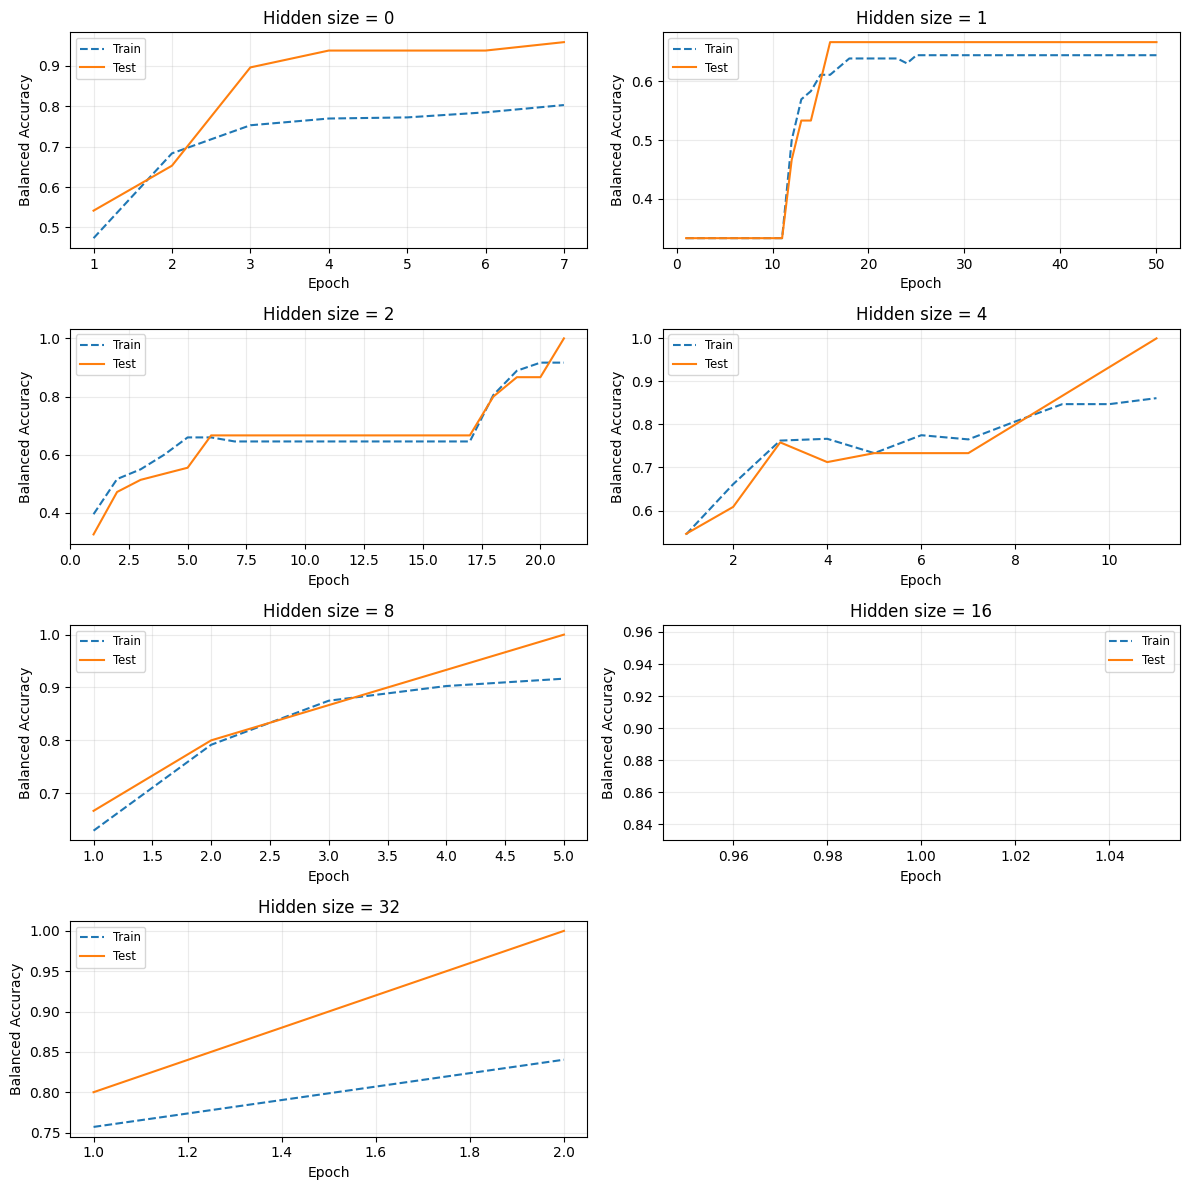

In [14]:
n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
axes = axes.flatten()

for i, h in enumerate(hidden_sizes):
    ax = axes[i]
    t = results[h]["train"]
    v = results[h]["test"]
    num_epochs = results[h]["num_epochs_used"]

    ax.plot(range(1, num_epochs+1), t, linestyle="--", label="Train")
    ax.plot(range(1, num_epochs+1), v, linestyle="-", label="Test")
    ax.set_title(f"Hidden size = {h}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Balanced Accuracy")
    ax.legend(fontsize="small")
    ax.grid(alpha=0.25)

# remove unused subplots (if hidden_sizes < 4*2)
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Incremental Class Learning

In [15]:
# chosen class counts: target_counts={0: 20, 1: 100, 2: 30}
class_order = np.array([0, 2, 1])

In [16]:
# implement incremental class learning
# 1. subset data
# 2. train model on subset
# 3. underfits? add hidden neurons and retrain
# 4. satisfactory performance? add next class and repeat from 1

def incr_class_learning(class_order, X_train, X_valid, y_train, y_valid):
    results = []
    hidden = 0
    for step in range(2, len(class_order)+1):
        # 1. subset data
        current_classes = class_order[:step]

        # create mapping: original label -> new label (for CrossEntropyLoss)
        label_map = {orig: new for new, orig in enumerate(current_classes)}
        
        # subset train and test data to only current classes
        mask_train = np.isin(y_train, current_classes)
        X_train_sub, y_train_sub = X_train[mask_train], y_train[mask_train]
        mask_valid = np.isin(y_valid, current_classes)
        X_valid_sub, y_valid_sub = X_valid[mask_valid], y_valid[mask_valid]
        
        # remap labels
        y_train_remap = np.vectorize(label_map.get)(y_train_sub)
        y_valid_remap = np.vectorize(label_map.get)(y_valid_sub)
        
        # convert everything to tensors
        X_train_tensor = torch.tensor(X_train_sub, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_remap, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid_sub, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid_remap, dtype=torch.long)
        
        # create datasets and dataloaders
        train_ds = TensorDataset(X_train_tensor, y_train_tensor)
        test_ds = TensorDataset(X_valid_tensor, y_valid_tensor)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
        
        print(f"Training on classes: {class_order[:step]}")
        print(f"Initial hidden size: {hidden}, output size: {step}")

        results.append({
            "classes": class_order[:step].tolist(),
            "hidden_tried": [],
            "train_hist": [],
            "test_hist": []
        })

        while True:
            # 2. train model on subset
            train_hist, test_hist, _ = tune_iris(hidden=hidden, output_size=step, epochs=50, lr=0.01, 
                                              train_loader=train_loader, test_loader=test_loader,
                                              classes_incl= iris.target_names[class_order[:step]], verbose=True)
            results[-1]["hidden_tried"].append(hidden)
            results[-1]["train_hist"].append(train_hist)
            results[-1]["test_hist"].append(test_hist)

            # TODO fine-tune this :)
            test_acc = np.array(test_hist)[-3:].mean()

            # 3. if underfitting, increase hidden and retrain
            # 4. if performance satisfactory, add next class
            if test_acc >= 0.8:
                print(f"Hidden size {hidden} achieved mean test balanced accuracy {test_acc}. Moving to next class.\n")
                break
            else:
                hidden += 1
                print(f"Underfitting detected (mean test balanced accuracy {test_acc}), increasing hidden size to {hidden}.\n")

    return results

In [17]:
np.random.seed(42)
torch.manual_seed(42)
results = incr_class_learning(class_order, X_train, X_test, y_train, y_test)

Training on classes: [0 2]
Initial hidden size: 0, output size: 2
h=0 Epoch 1/50 | tr_bal_acc=0.312 te_bal_acc=0.000
Satisfactory performance reached at epoch 9, te_bal_acc=1.000
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000         1
   virginica      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

Underfitting detected (mean test balanced accuracy 0.6666666666666666), increasing hidden size to 1.

h=1 Epoch 1/50 | tr_bal_acc=0.500 te_bal_acc=0.500
Satisfactory performance reached at epoch 3, te_bal_acc=1.000
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000         1
   virginica      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighte

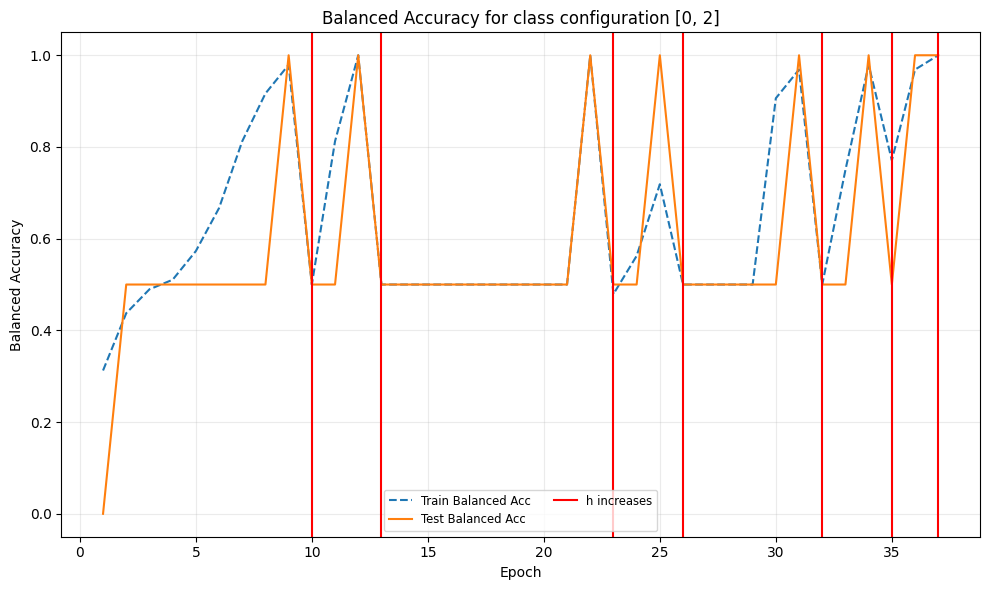

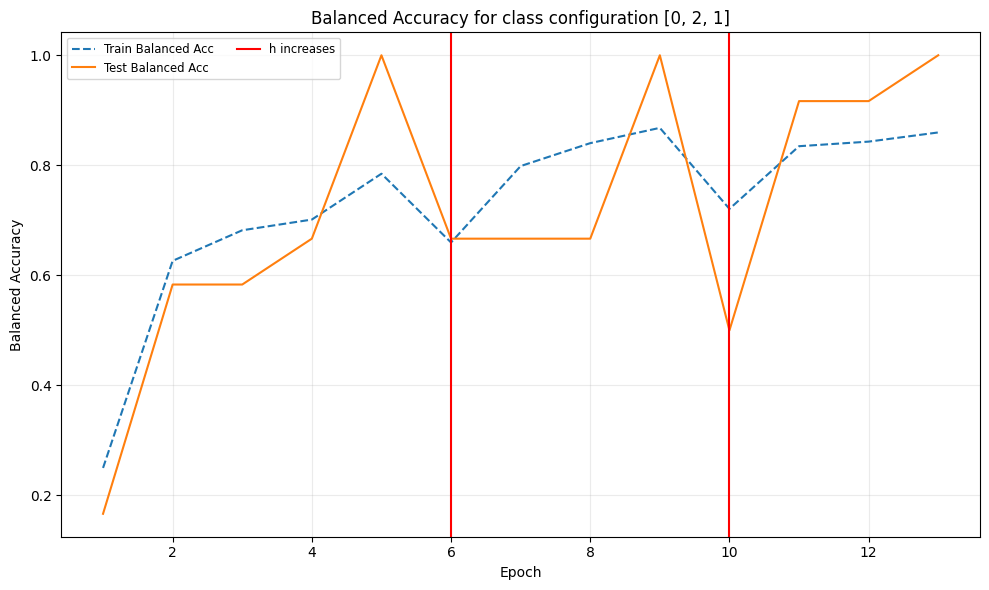

In [18]:
for i in range(len(results)):
    config_results = results[i]

    plt.figure(figsize=(10, 6))

    # concatenate results for all hidden sizes tried for this class configuration
    train_acc = []
    test_acc = []
    h_change_epochs = []
    epoch_counter = 0

    for i, h in enumerate(config_results["hidden_tried"]):
        t = config_results["train_hist"][i]
        v = config_results["test_hist"][i]
        train_acc.extend(t)
        test_acc.extend(v)
        if i > 0:
            h_change_epochs.append(epoch_counter)
        epoch_counter += len(t)

    epochs_total = range(1, len(train_acc) + 1)
    plt.plot(epochs_total, train_acc, linestyle="--", label="Train Balanced Acc")
    plt.plot(epochs_total, test_acc, linestyle="-", label="Test Balanced Acc")

    for xc in h_change_epochs:
        plt.axvline(x=xc + 1, color='red', linestyle='-', label='h increases' if xc == h_change_epochs[0] else None)

    plt.xlabel("Epoch")
    plt.ylabel("Balanced Accuracy")
    plt.title(f"Balanced Accuracy for class configuration {config_results['classes']}")
    plt.legend(ncol=2, fontsize="small")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

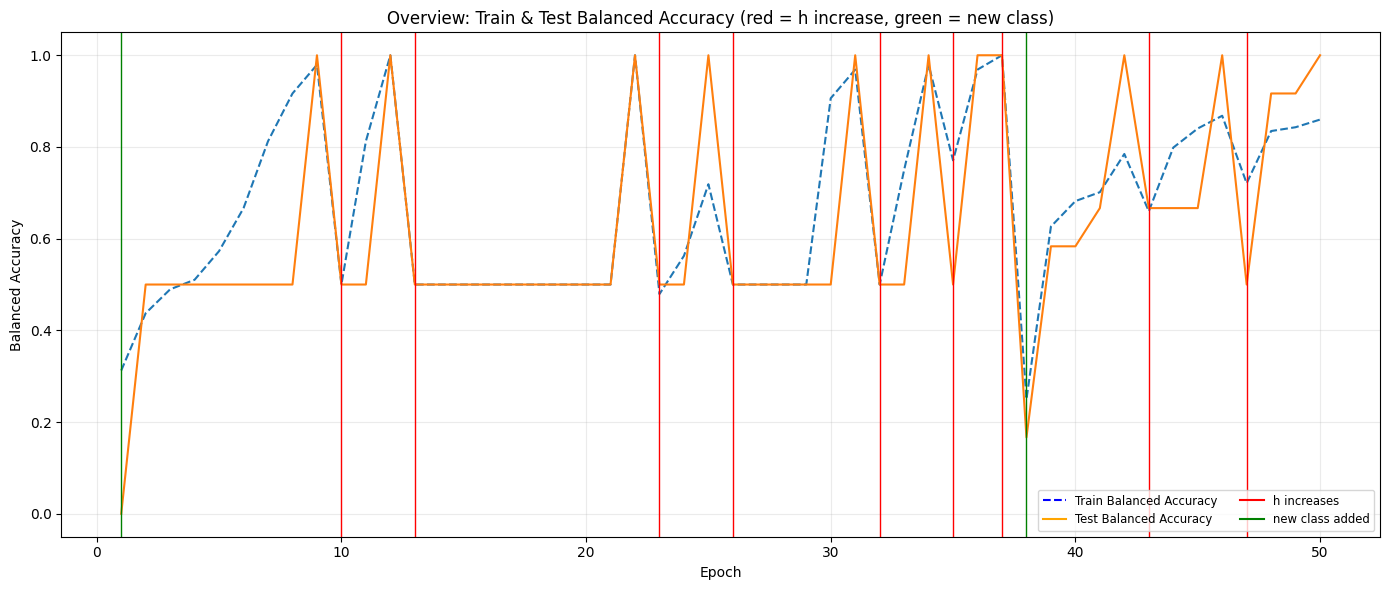

<Figure size 640x480 with 0 Axes>

In [20]:
# Replace your plotting loop with this single overview plot (uses the same `results` structure)
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

train_acc = []
test_acc = []
h_change_epochs = []
class_change_epochs = []
cumulative_epoch = 0

for step_idx, config_results in enumerate(results):
    # mark where this class-configuration starts (new class added)
    class_change_epochs.append(cumulative_epoch + 1)  # 1-based epoch index

    for j, h in enumerate(config_results["hidden_tried"]):
        t = config_results["train_hist"][j]
        v = config_results["test_hist"][j]

        # if this is not the first trial for this class config, a hidden-size increase happened
        if j > 0:
            h_change_epochs.append(cumulative_epoch + 1)

        train_acc.extend(t)
        test_acc.extend(v)
        cumulative_epoch += len(t)

epochs_total = range(1, len(train_acc) + 1)
plt.figure(figsize=(14, 6))
plt.plot(epochs_total, train_acc, linestyle="--", label="Train Balanced Accuracy")
plt.plot(epochs_total, test_acc, linestyle="-", label="Test Balanced Accuracy")

# vertical lines: hidden increases (red) and new class added (green)
for xc in h_change_epochs:
    plt.axvline(x=xc, color="red", linestyle="-", linewidth=1)

for xc in class_change_epochs:
    plt.axvline(x=xc, color="green", linestyle="-", linewidth=1)

# build a clean legend (avoid duplicate axis labels)
train_line = mlines.Line2D([], [], linestyle="--", label="Train Balanced Accuracy", color="blue")
test_line = mlines.Line2D([], [], linestyle="-", label="Test Balanced Accuracy", color ="orange")
h_line = mlines.Line2D([], [], color="red", linestyle="-", label="h increases")
c_line = mlines.Line2D([], [], color="green", linestyle="-", label="new class added")
plt.legend(handles=[train_line, test_line, h_line, c_line], ncol=2, fontsize="small")

plt.xlabel("Epoch")
plt.ylabel("Balanced Accuracy")
plt.title("Overview: Train & Test Balanced Accuracy (red = h increase, green = new class)")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
plt.savefig("iris_inc.png")